## Modeling neighbhood movements in Brooklyn using a Markov chain process

In [2]:
import imageio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import time
from IPython.display import HTML

In [9]:
sns.set_style('white')
# filters to apply to the data
county = 'Kings'
hoods  = ['Downtown', 'DUMBO', 'Fort Greene', 'Boerum Hill', 'Clinton Hill']

def get_neighborhoods(file, county=county, neighborhoods=hoods):
    '''
    reads in geopandas file from Zillow, returns geodataframe with specified neighborhoods
    '''
    ny_gdf = gpd.read_file(file)
    ny_gdf = ny_gdf[ny_gdf['County'] == county]
    ny_gdf = ny_gdf[ny_gdf['Name'].isin(neighborhoods)]
    
    # locate coordinate points to plot neighborhood names
    ny_gdf['coords'] = ny_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    ny_gdf['coords'] = [coords[0] for coords in ny_gdf['coords']]
    return ny_gdf

bk_neighborhoods = get_neighborhoods('ZillowNeighborhoodsNY.shp')
bk_neighborhoods = bk_neighborhoods.sort_values('Name').reset_index(drop=True)
bk_neighborhoods

,State,County,City,Name,RegionID,geometry,coords
0,NY,Kings,New York,Boerum Hill,272994,POLYGON ((-73.98682489707035 40.68846655576456...,"(-73.9864896425407, 40.68600290969882)"
1,NY,Kings,New York,Clinton Hill,270815,"POLYGON ((-73.9619257224787 40.69778778197278,...","(-73.96455445229091, 40.689058350724)"
2,NY,Kings,New York,DUMBO,270841,POLYGON ((-73.98446723099994 40.70646091900005...,"(-73.99003960915954, 40.703545669500045)"
3,NY,Kings,New York,Downtown,270825,POLYGON ((-73.98697203810939 40.70105040762233...,"(-73.98678098579373, 40.693458468711725)"
4,NY,Kings,New York,Fort Greene,273766,POLYGON ((-73.98230754099966 40.70227250100029...,"(-73.97573066517539, 40.69136863239475)"


Above we can see the geodataframe. Now let's plot it: 

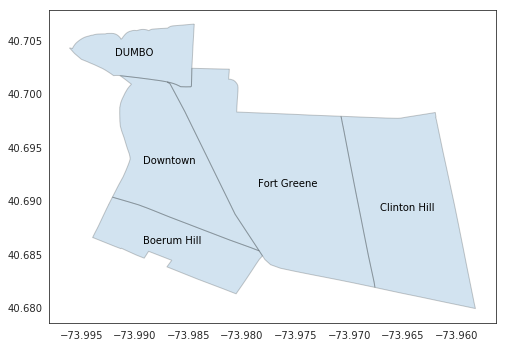

In [10]:
bk_neighborhoods.plot(figsize=(8, 6), edgecolor='black', alpha=0.2)

for idx, row in bk_neighborhoods.iterrows():
    plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)

Here, we define the likelihoods of moving from one neighborhood to another.
Use a Dirichlet Distrobution (convenient for generating samples that sum to 1.0) to obtain an initial starting population for the neighborhoods https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.dirichlet.html

In [39]:
np.random.seed(42)
data = np.random.dirichlet(alpha=[10,4,2,10,20], size=1)

#####your code here##### # use a dirichlet distribution to create a 1-by-5 matrix of values that sum to 1.0 
initial_vals = zip(list(bk_neighborhoods.Name), np.array(data)[0])

print('Initial allocations:')
print('--------------------')
for i, j in initial_vals:
    print('{:<13s} {:>5.2f}%'.format(i, round(j, 4)*100))
print('--------------------')
print()

move_likelihoods = np.matrix('0.4 0.1 0.1 0.2 0.2; 0.1 0.4 0.1 0.15 0.25; 0.1 0.1 0.4 0.2 0.2;' 
                             + '0.2 0.05 0.15 0.4 0.2; 0.15 0.2 0.05 0.2 0.4')
pd.DataFrame(data=move_likelihoods, index=bk_neighborhoods.Name, columns=bk_neighborhoods.Name) 
# we could use 'tabulate' here, as this is for visualization purposes, but a pd dataframe is 
# often just as clear and has more compatability with python environments

Initial allocations:
--------------------
Boerum Hill   21.48%
Clinton Hill   6.48%
DUMBO          2.63%
Downtown      17.04%
Fort Greene   52.37%
--------------------



Name,Boerum Hill,Clinton Hill,DUMBO,Downtown,Fort Greene
Name,,,,,
Boerum Hill,0.40,0.10,0.10,0.20,0.20
Clinton Hill,0.10,0.40,0.10,0.15,0.25
DUMBO,0.10,0.10,0.40,0.20,0.20
Downtown,0.20,0.05,0.15,0.40,0.20
Fort Greene,0.15,0.20,0.05,0.20,0.40


Here we will build a Markov process and visualize it in a GIF; this is useful for seeing equilibrium state reached over time. We will then look at the numbers to confirm what the plot is showing us. 

In [44]:
years = 7
pct_by_year = []

initial_pos = np.matrix('21.48 6.48 2.63 17.04 52.37')

#rat_postc * np.linalg.matrix_power(move_likelihoods, i)

def plot_neighborhood_movement(years):

    pct_in_hood = initial_pos * np.linalg.matrix_power(move_likelihoods, years)
    #####your code here##### # use the matrix_power function to run a step in the markov process
    bk_neighborhoods['pct_in_hood'] = np.array(pct_in_hood)[0]
    pct_by_year.append(np.array(pct_in_hood)[0])
    vmin, vmax = bk_neighborhoods['pct_in_hood'].min(), bk_neighborhoods['pct_in_hood'].max()

    fig, ax = plt.subplots(figsize=(8,6))
    base = bk_neighborhoods.plot(ax=ax, column='pct_in_hood', edgecolor='grey', 
                                cmap='Blues', vmin=vmin, vmax=vmax, legend=False)

    plt.title('Year:{}'.format(years), size=16)
    
    for idx, row in bk_neighborhoods.iterrows():
        
        plt.annotate(s=row['Name'], xy=row['coords'], color='red', horizontalalignment='center', size=10)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('neighborhood_movement.gif', [plot_neighborhood_movement(year) for year in range(years)], fps=1)

HTML('<img src="neighborhood_movement.gif">')

#### Since Fort Green stats with a high initial position of ~52 and has strong propensity to remain in the neighborhood it stays a high concentration through all 7 Markov processes. Downtown, due to it's relative pull from Fort Green gains a lot of population, while DUMBO, which has low initial population and little propensity for movement from other areas into DUMBO it stays sparse for the entire 7 iterations. If we ran this for 100 iterations we would see a continuation of the trend to have higher population density in downtown, while Fort Greene would remain high, Boerum Hill in the middle, followed by Clinton Hill and then DUMBO, which has a steady state low population.